# Building Blocks 4 RBIG

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", True)

import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss

KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In [3]:
from rbig_jax.data import NoisySineDataset as PlaneDataset
from sklearn.preprocessing import StandardScaler

# %%wandb
# get data
seed = 123
n_samples = 1_000_000
n_features = 2
noise = 0.1
n_train = 5_000
n_valid = 1_000

ds = PlaneDataset(n_samples=n_train, noise=noise, seed=seed)

data = ds[:]

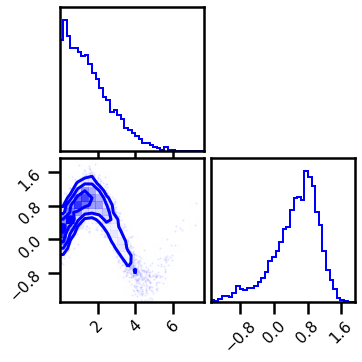

In [4]:
# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)

In [5]:
X = jnp.array(data, dtype=np.float64)

## Model

### Layer I - Univariate Histogram

In [9]:
from rbig_jax.transforms.histogram import InitUniHistTransform

# histogram params
support_extension = 20
alpha = 1e-5
precision = 1_000
nbins = None  # init_bin_estimator("sqrt") #bins #cott"#int(np.sqrt(X.shape[0]))
jitted = True

# initialize
shape = X.shape
n_samples = shape[0]
init_hist_f = InitUniHistTransform(
    n_samples=n_samples, support_extension=support_extension
)

#### Init Function

Text(0.5, 0.98, 'Gradient Transformation')

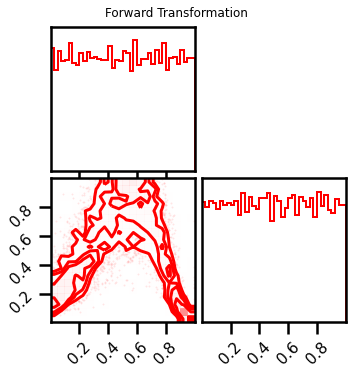

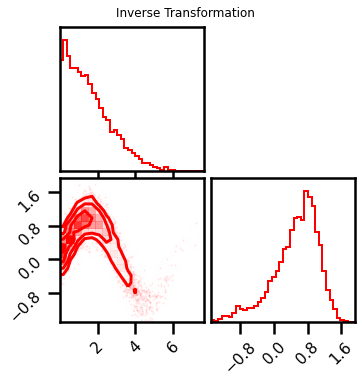

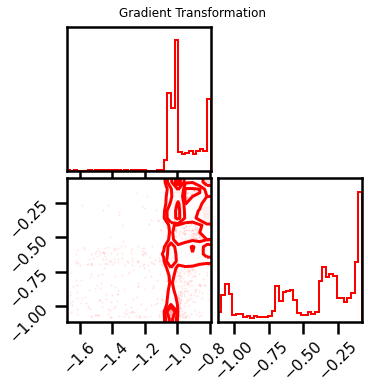

In [10]:
# initialize bijector
X_u, hist_bijector = init_hist_f.transform_and_bijector(X)

# forward transformation
X_l1 = hist_bijector.forward(X)

# inverse transformation
X_approx = hist_bijector.inverse(X_l1)

# gradient transformation
X_l1_ldj = hist_bijector.forward_log_det_jacobian(X_l1)

# plot Transformations
fig = corner.corner(X_l1, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")
fig = corner.corner(X_approx, color="red", hist_bin_factor=2)
fig.suptitle("Inverse Transformation")
fig = corner.corner(X_l1_ldj, color="red", hist_bin_factor=2)
fig.suptitle("Gradient Transformation")

In [11]:
from rbig_jax.transforms.histogram import InitUniHistTransform, init_bin_estimator
from rbig_jax.transforms.kde import InitUniKDETransform, estimate_bw

# histogram params
support_extension = 20
alpha = 1e-5
precision = 1_000
nbins = None  # init_bin_estimator("sqrt") #bins #cott"#int(np.sqrt(X.shape[0]))
jitted = True

# KDE specific Transform
bw = "scott"  # estimate_bw(X.shape[0], 1, "scott")

method = "kde"

In [12]:
# initialize histogram transformation
if method == "histogram":

    init_hist_f = InitUniHistTransform(
        n_samples=X.shape[0],
        nbins=nbins,
        support_extension=support_extension,
        precision=precision,
        alpha=alpha,
        jitted=jitted,
    )
elif method == "kde":

    init_hist_f = InitUniKDETransform(
        shape=X.shape, support_extension=support_extension, precision=precision, bw=bw
    )
else:
    raise ValueError(f"Unrecognized transform: {method}")

#### Transformations

Text(0.5, 0.98, 'Gradient Transformation')

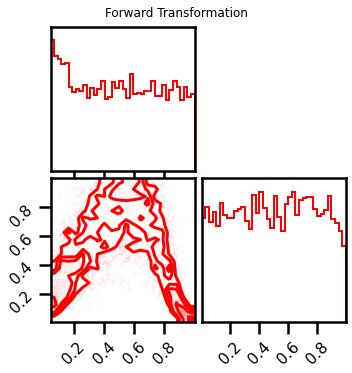

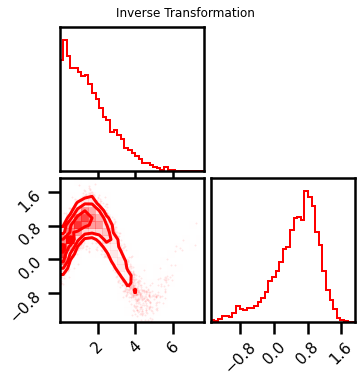

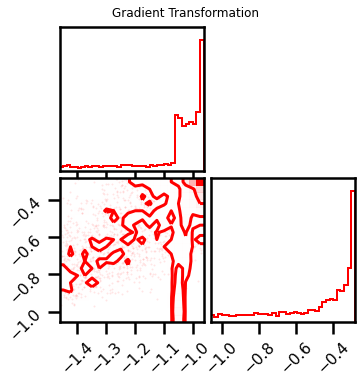

In [13]:
# initialize bijector
X_u, hist_bijector = init_hist_f.transform_and_bijector(X)

# forward transformation
X_l1 = hist_bijector.forward(X)

# inverse transformation
X_approx = hist_bijector.inverse(X_l1)

# gradient transformation
X_l1_ldj = hist_bijector.forward_log_det_jacobian(X_l1)

# plot Transformations
fig = corner.corner(X_l1, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")
fig = corner.corner(X_approx, color="red", hist_bin_factor=2)
fig.suptitle("Inverse Transformation")
fig = corner.corner(X_l1_ldj, color="red", hist_bin_factor=2)
fig.suptitle("Gradient Transformation")

### Layer II - Inverse Gaussian CDF

In [14]:
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF

# univariate normalization Gaussianization parameters
eps = 1e-5
jitted = True

# initialize histogram transformation
init_icdf_f = InitInverseGaussCDF(eps=eps, jitted=jitted)

#### Transformations

In [15]:
# forward with bijector
X_l2, icdf_bijector = init_icdf_f.transform_and_bijector(X_l1)

# alternatively - forward with no bijector
X_l2_ = icdf_bijector.forward(X_l1)

chex.assert_tree_all_close(X_l2_, X_l2)

# inverse transformation
X_l1_approx = icdf_bijector.inverse(X_l2)
chex.assert_tree_all_close(X_l1_approx, X_l1, rtol=1e-5)

# gradient transformation
X_l2_ldj = icdf_bijector.forward_log_det_jacobian(X_l1)

Text(0.5, 0.98, 'Gradient Transformation')

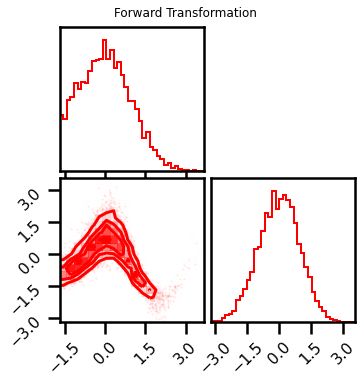

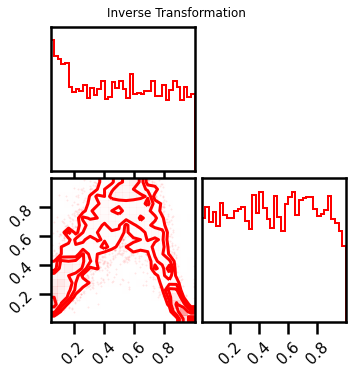

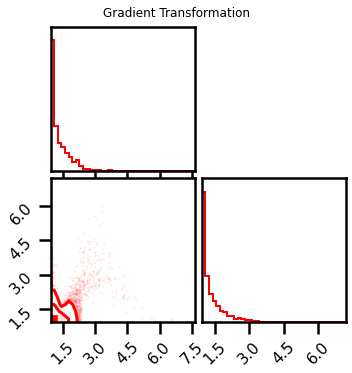

In [16]:
# plot Transformations
fig = corner.corner(X_l2, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")
fig = corner.corner(X_l1_approx, color="red", hist_bin_factor=2)
fig.suptitle("Inverse Transformation")
fig = corner.corner(X_l2_ldj, color="red", hist_bin_factor=2)
fig.suptitle("Gradient Transformation")

### PCA Transformation

In [17]:
from rbig_jax.transforms.rotation import InitPCARotation

# initialize histogram transformation
init_pca_f = InitPCARotation(jitted=True)

In [18]:
# forward with bijector
X_l3, pca_bijector = init_pca_f.transform_and_bijector(X_l2)

# alternatively - forward with no bijector
X_l3_ = pca_bijector.forward(X_l2)

chex.assert_tree_all_close(X_l3_, X_l3)

# inverse transformation
X_l2_approx = pca_bijector.inverse(X_l3)

chex.assert_tree_all_close(X_l2_approx, X_l2, rtol=1e-3)

# gradient transformation
X_l3_ldj = pca_bijector.forward_log_det_jacobian(X_l2)

chex.assert_tree_all_close(X_l3_ldj, jnp.zeros_like(X_l3_ldj))

Text(0.5, 0.98, 'Inverse Transformation')

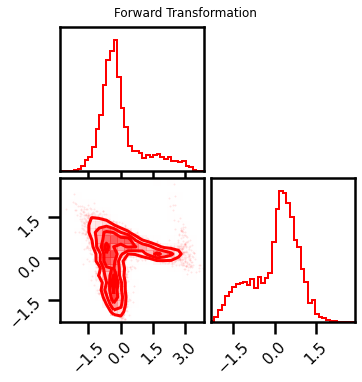

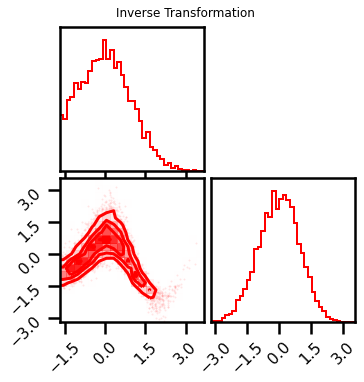

In [19]:
# plot Transformations
fig = corner.corner(X_l3, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")
fig = corner.corner(X_l2_approx, color="red", hist_bin_factor=2)
fig.suptitle("Inverse Transformation")

## RBIG Blocks

1. Marginal Gaussianization
2. Random Rotation

In [20]:
from rbig_jax.transforms.block import RBIGBlockInit

# create a list of transformations
init_functions = [init_hist_f, init_icdf_f, init_pca_f]

# create an RBIG "block" init
rbig_block_init = RBIGBlockInit(init_functions=init_functions)

In [22]:
# forward and params
X_g, bijectors = rbig_block_init.forward_and_bijector(X)

# alternatively just the forward
X_g = rbig_block_init.forward(X)

Text(0.5, 0.98, 'Forward Transformation')

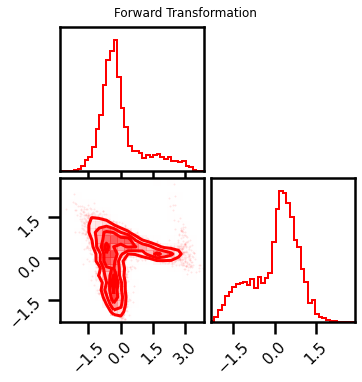

In [23]:
fig = corner.corner(X_g, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")

## Forward and Inverse Transformations

So here we want to be able to chain the transformations together. We have initialized our bijectors but it would be nice to have a convenient way to loop through them calculating all of the quanties, e.g. `forward`, `inverse`, `log_det_jacobian` and some combination of them.

In this package, we have the `BijectorChain` class which gives us that flexibility.

In [24]:
from rbig_jax.transforms.base import BijectorChain

# create a list of BIJECTORS (not init functions)
bijectors = [hist_bijector, icdf_bijector, pca_bijector]

# create rbig_block
rbig_block = BijectorChain(bijectors=bijectors)

In [25]:
# forward with bijector
X_l3 = rbig_block.forward(X)

# inverse transformation
X_approx = rbig_block.inverse(X_l3)

chex.assert_tree_all_close(X_approx, X, rtol=1e-4)

# gradient transformation
X_l3_ldj = rbig_block.forward_log_det_jacobian(X)

# forward and gradient transformation
X_l3_, X_l3_ldj_ = rbig_block.forward_and_log_det(X)

chex.assert_tree_all_close(X_l3_, X_l3)
chex.assert_tree_all_close(X_l3_ldj, X_l3_ldj_)

Text(0.5, 0.98, 'Gradient Transformation')

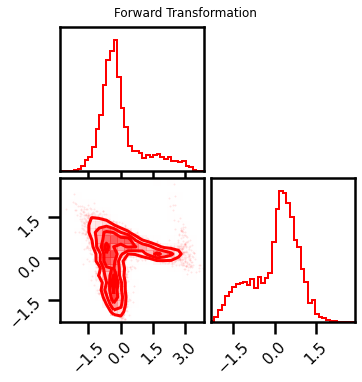

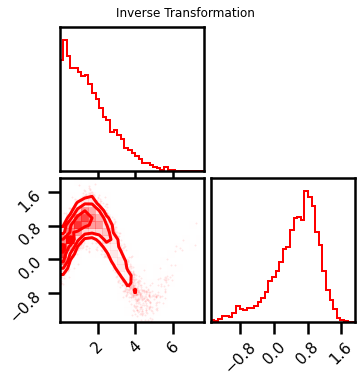

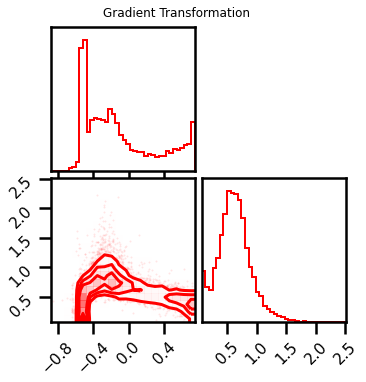

In [26]:
# plot Transformations
fig = corner.corner(X_l3, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")
fig = corner.corner(X_approx, color="red", hist_bin_factor=2)
fig.suptitle("Inverse Transformation")
fig = corner.corner(X_l3_ldj, color="red", hist_bin_factor=2)
fig.suptitle("Gradient Transformation")

## Multiple Layers

So it's very evident that a single RBIG block isn't enough. We need multiple layers. So all we need to do is loop through the `init_` methods until we are satisfied. Then once we're done, we can create another chain and check how good is our transformation.

In [28]:
%%time

import itertools

itercount = itertools.count(-1)

n_blocks = 20

# initialize rbig block
init_functions = [
    init_hist_f,
    init_icdf_f,
    init_pca_f
]

# initialize RBIG Init Block
rbig_block_init = RBIGBlockInit(init_functions=init_functions)

# initialize list of bijectors
bijectors = list()

# initialize transform
X_g = X.copy()

plot_steps = False

while next(itercount) < n_blocks:
    
    # fit RBIG block
    X_g, ibijector = rbig_block_init.forward_and_bijector(X_g)
    
    if plot_steps:
        fig = corner.corner(X_g, color="blue", hist_bin_factor=2)
    
    # append bijectors 
    bijectors += ibijector

CPU times: user 1min 8s, sys: 10 s, total: 1min 18s
Wall time: 9.09 s


#### Check Transformation

Now let's check the Gaussianized data to see how well we did.

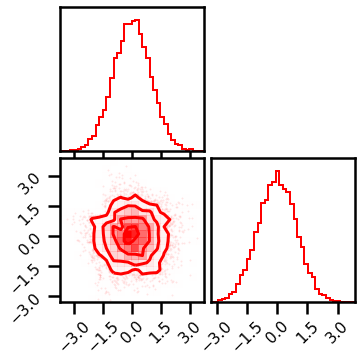

In [29]:
fig = corner.corner(X_g, color="red", hist_bin_factor=2)

This looks pretty good. So let's see how good the inverse transformation. Again, we create a `bijectorchain` which will loop through all of the transformations



In [30]:
# create rbig_model
rbig_model = BijectorChain(bijectors=bijectors)

In [31]:
%%time
# forward with bijector
X_g_ = rbig_model.forward(X)

chex.assert_tree_all_close(X_g_, X_g, rtol=1e-4)

# inverse transformation
X_approx = rbig_model.inverse(X_g)

chex.assert_tree_all_close(X_approx, X, rtol=1e-2)

# gradient transformation
X_g_ldj = rbig_model.forward_log_det_jacobian(X)

# forward and gradient transformation
X_g__, X_g_ldj_ = rbig_model.forward_and_log_det(X)

chex.assert_tree_all_close(X_g__, X_g_)
chex.assert_tree_all_close(X_g_ldj, X_g_ldj_)

CPU times: user 9.81 s, sys: 504 ms, total: 10.3 s
Wall time: 8.6 s


Text(0.5, 0.98, 'Gradient Transformation')

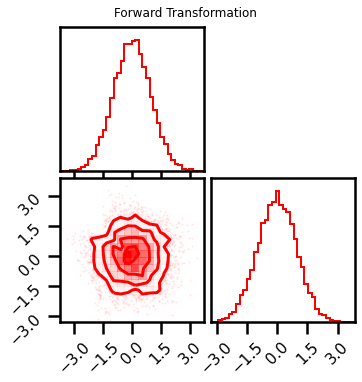

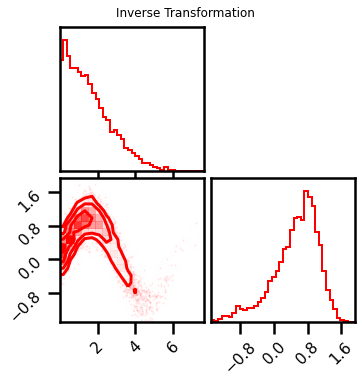

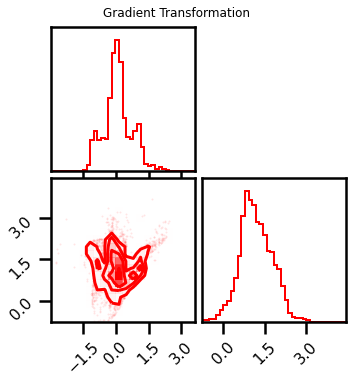

In [32]:
# plot Transformations
fig = corner.corner(X_g, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")
fig = corner.corner(X_approx, color="red", hist_bin_factor=2)
fig.suptitle("Inverse Transformation")
fig = corner.corner(X_g_ldj, color="red", hist_bin_factor=2)
fig.suptitle("Gradient Transformation")

## Gaussianization Flow

The bijector chains allow us to do some extra things like density estimation or sampling. So we can also use the `GaussianizationFlow` class which is exactly like the `BijectorChain` class but with some additional benefits like calculating log probabilities. This may seem very redundant for the iterative method, but it is very helpful for fully parameterized Gaussianization; i.e. the end result is the same but the way to find the parameters are different.

In [33]:
from rbig_jax.models import GaussianizationFlow
from distrax._src.distributions.normal import Normal

# initialize base distribution
base_dist = Normal(jnp.zeros((2,)), jnp.ones((2,)))

# initialize flow model
rbig_model = GaussianizationFlow(base_dist=base_dist, bijectors=bijectors)

### Density Estimation

Here we will do an example of density estimation. In this example, 

So here we will do an example of density estimation.
The same pythn code below is equivalent.

```python
# propagate through the chain
X_g_grid, X_ldj_grid = rbig_model.forward_and_log_det(xyinput)

# calculate log prob
base_dist = Normal(jnp.zeros((2,)), jnp.ones((2,)))

latent_prob = base_dist.log_prob(X_g_grid)

# calculate log probability
X_log_prob = latent_prob.sum(axis=1) + X_ldj_grid.sum(axis=1)
```

However, using the `score_samples` method is a lot more convenient.

In [34]:
%%time
from rbig_jax.data import generate_2d_grid

# generate inputs
xyinput = generate_2d_grid(X, 200, buffer=0.1)

X_log_prob = rbig_model.score_samples(xyinput)

CPU times: user 6.36 s, sys: 315 ms, total: 6.68 s
Wall time: 4.24 s


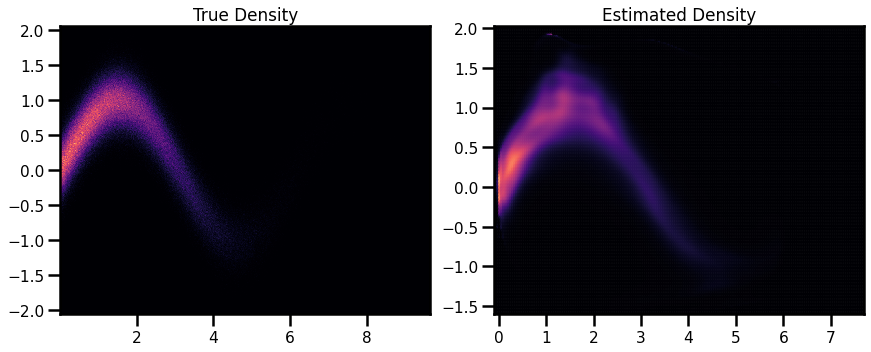

In [35]:
# Original Density
from matplotlib import cm

n_samples = 1_000_000
n_features = 2
ds = PlaneDataset(n_samples=n_samples, seed=42)
X_plot = ds[:]
# X_plot = scaler.transform(X_plot)

# Estimated Density
cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)


fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
h = ax[0].hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
)
ax[0].set_title("True Density")
ax[0].set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
)

h1 = ax[1].scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
)
# plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()

### Score (Negative Log-Likelihood)


In [36]:
nll = rbig_model.score(X)
print(f"NLL Score: {nll:.4f}")

NLL Score: 1.4940


### Sampling

This is another useful application.

In [37]:
%%time

# number of samples
n_samples = 100_000
seed = 42

X_samples = rbig_model.sample(seed=seed, n_samples=n_samples)

CPU times: user 6.13 s, sys: 503 ms, total: 6.63 s
Wall time: 2.69 s


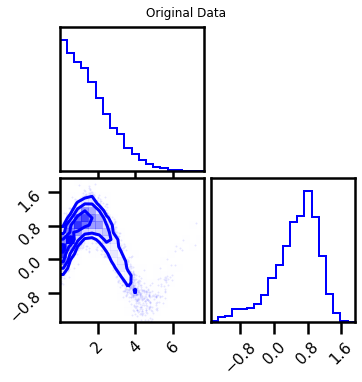

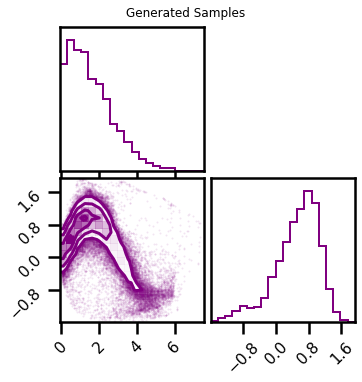

In [38]:
fig = corner.corner(X, color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(X_samples, color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Better Training

So we assumed that there would be $20$ layers necessary in order to train the model. But how do we know that it's the best model? This would require some *stopping criteria* instead of just an ad-hoc procedure. 

In RBIG, we use the **information reduction** loss which essentially checks how much information content is being removed with each iteration. We are effectively creating a more and more independent distribution with every marginal Gaussianization + rotation. So naturally, we can simply check how much the information is being reduced between iterations. If there are no changes, we can stop.

#### Loss Function

We can initialize the info loss function here.

In [39]:
from rbig_jax.losses import init_info_loss

# define loss parameters
max_layers = 1_000
zero_tolerance = 60
p = 0.25
base = 2
jitted = True

# initialize info loss function
loss = init_info_loss(
    n_samples=X.shape[0],
    max_layers=max_layers,
    zero_tolerance=zero_tolerance,
    p=p,
    base=base,
    jitted=jitted,
)

#### Training

In [ ]:
from rbig_jax.training.iterative import train_info_loss_model

# define training params
verbose = True
n_layers_remove = 50
interval = 10

# run iterative training
X_g, rbig_model_info = train_info_loss_model(
    X=X,
    rbig_block_init=rbig_block_init,
    loss=loss,
    verbose=verbose,
    interval=interval,
    n_layers_remove=n_layers_remove,
)

Layer 10 - Cum. Info Reduction: 1.598 - Elapsed Time: 6.1235 secs
Layer 20 - Cum. Info Reduction: 1.598 - Elapsed Time: 10.4455 secs


#### Information Reduction Evolution

In [ ]:
fig, ax = plt.subplots()
ax.plot(rbig_model_info.info_loss, color="red")
ax.set(xlabel="Iterations", ylabel="$\Delta$ Info. Reduction")
plt.show()

#### Negative Log-Likelihood

In [ ]:
nll = rbig_model_info.score(X)
print(f"NLL Score: {nll:.4f}")

#### Density Estimation (Revisited)

In [ ]:
from rbig_jax.data import generate_2d_grid

# generate inputs
xyinput = generate_2d_grid(X, 200, buffer=0.1)

X_log_prob = rbig_model_info.score_samples(xyinput)

In [ ]:
# Estimated Density
cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)


fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
h = ax[0].hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
)
ax[0].set_title("True Density")
ax[0].set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
)

h1 = ax[1].scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
)
# plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()

#### Sampling Revisited

In [ ]:
%%time

# number of samples
n_samples = 100_000
seed = 42

X_samples = rbig_model_info.sample(seed=seed, n_samples=n_samples)

In [ ]:
fig = corner.corner(X, color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(X_samples, color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Saving and Loading

Often times it would be nice to save and load models. This is useful for checkpointing (during training) and also for convenience if you're doing research on google colab.

Fortunately, everything here are python objects, so we can easily save and load our models via `pickle`.

#### Saving

Do to the internals of python (and design choices within this library), one can only store `objects`. So that includes the `rbig_block`, the `bijectors` and also the `rbig_model`. This does not include the `rbig_block_init` for example because that isn't an object, it's a function with some local params.

In [46]:
import pickle

# # save the blocks
# with open("rbig_block.pickle", "wb") as f:
#     pickle.dump(rbig_block, f)

# # save the bijectors
# with open("bijectors.pickle", "wb") as f:
#     pickle.dump(bijectors, f)

# save the full model
import joblib

joblib.dump(rbig_model, "rbig_model_test.pickle")

['rbig_model_test.pickle']

#### Loading

Loading is straight forward!

In [47]:
rbig_model_loaded = joblib.load("rbig_model_test.pickle")

#### Simple Test

They won't be the **exact same** byte-for-byte encoding. But they should give the same results either way :).

In [48]:
# nll for the old model
nll = rbig_model_info.score(X)
print(f"Negative Log-Likelihood: {nll:.4f}")

# nll for the loaded model
nll = rbig_model_loaded.score(X)
print(f"Negative Log-Likelihood: {nll:.4f}")

Negative Log-Likelihood: 1.4973
Negative Log-Likelihood: 1.4940
